In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle
import glob
from sklearn.metrics import root_mean_squared_error
import torch
from datetime import datetime
from lib.models import *
from lib.tes import *
from lib.TES_vec import ecostress_tes
from lib.utils import *
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

plt.rcParams['font.family'] = 'Times New Roman'
root_folder = r'H:\data\ecostress' # replace with your own path containing the ECOSTRESS data for cross-validation

lamda = np.array([8.8161,10.4919,12.0876])
coefs = np.load('result/sw_tes/coefs_sw_tes.npy')
Ld_modtran = np.load('result/sw_tes/Ld_modtran.npy')
Ld_LUT = np.load('result/sw_tes/Ld_LUT.npy') # T:0, MLS:1, MLW:2, SAS:3, SAW:4

# read data and run TES

In [2]:
folder = rf'{root_folder}\iran'
files = sorted(glob.glob(folder + '/*.h5'))
date_string = files[0].split('_')[-3]
date = datetime.strptime(date_string, "%Y%m%dT%H%M%S")
month = date.month # + date.day/30
files

['H:\\data\\ecostress\\iran\\ECOSTRESS_L1B_GEO_26394_008_20230302T204757_0601_01.h5',
 'H:\\data\\ecostress\\iran\\ECOSTRESS_L1B_RAD_26394_008_20230302T204757_0601_01.h5',
 'H:\\data\\ecostress\\iran\\ECOSTRESS_L2_CLOUD_26394_008_20230302T204757_0601_01.h5',
 'H:\\data\\ecostress\\iran\\ECOSTRESS_L2_LSTE_26394_008_20230302T204757_0601_01.h5']

In [3]:
lat, lon, vza, rad2, rad4, rad5, lst_eco, pwv, qa, land_fraction = Read_ECOSTRESS(files[0], files[1], files[3])
lat_min, lat_max, lon_min, lon_max = np.min(lat), np.max(lat), np.min(lon), np.max(lon)
# qa_mandatory = extract_bit_vec(qa, 16, 1, 0)
qa_mandatory = np.load(f'{folder}/qa_mandatory.npy')
idx_valid = (lst_eco>0) & (qa_mandatory==0) & (land_fraction>=0.5)

In [58]:
# SWDTES
# Lg estimation
L2 = rad2[idx_valid]
L4 = rad4[idx_valid]
L5 = rad5[idx_valid]
tpw = pwv[idx_valid] * 10 # cm to mm

T2 = Inverse_Planck_law(L2, lamda[0])
T4 = Inverse_Planck_law(L4, lamda[1])
T5 = Inverse_Planck_law(L5, lamda[2])

swdtes_calculator = SWDTES_calculator_vec()
lst_swdes, emi_swdtes, qa_swdtes = swdtes_calculator(T2[:,None], T4[:,None], T5[:,None], tpw[:,None], t1=0.05)

out_t = lst_swdes.squeeze()
out_qa = qa_swdtes.squeeze()

lst_wang, qa_wang = np.full_like(lst_eco, np.nan), np.full_like(qa, 0)
lst_wang[idx_valid], qa_wang[idx_valid] = out_t, out_qa
lst_wang[qa_wang!=1] = np.nan

np.save(folder + '\lst_wang.npy', lst_wang.astype(np.float32))
np.save(folder + '\qa_wang.npy', qa_wang.astype(np.int16))

SWDTES starting...
NEM Iteration: 1
Undecided pixels: 27033252
NEM Iteration: 2
Undecided pixels: 27021204
NEM Iteration: 3
Undecided pixels: 26959684
NEM Iteration: 4
Undecided pixels: 26679133
NEM Iteration: 5
Undecided pixels: 24907936
NEM Iteration: 6
Undecided pixels: 17245724
NEM Iteration: 7
Undecided pixels: 8311844
NEM Iteration: 8
Undecided pixels: 2338200
NEM Iteration: 9
Undecided pixels: 535023
NEM Iteration: 10
Undecided pixels: 91011
NEM Iteration: 11
Undecided pixels: 8237
NEM Iteration: 12
Undecided pixels: 449
NEM Iteration: 13
Undecided pixels: 8
All pixels completed
NEM Iteration: 1
Undecided pixels: 3243877
NEM Iteration: 2
Undecided pixels: 3221854
NEM Iteration: 3
Undecided pixels: 3163609
NEM Iteration: 4
Undecided pixels: 3062628
NEM Iteration: 5
Undecided pixels: 2835267
NEM Iteration: 6
Undecided pixels: 2173917
NEM Iteration: 7
Undecided pixels: 1236058
NEM Iteration: 8
Undecided pixels: 464442
NEM Iteration: 9
Undecided pixels: 118911
NEM Iteration: 10
Unde

In [48]:
# SW-TES
# Lg estimation
L2 = rad2[idx_valid]
L4 = rad4[idx_valid]
L5 = rad5[idx_valid]

T2 = Inverse_Planck_law(L2, lamda[0])
T4 = Inverse_Planck_law(L4, lamda[1])
T5 = Inverse_Planck_law(L5, lamda[2])

d_T2_T5 = T2 - T5
d_T2_T5_2 = d_T2_T5**2
Tg2 = coefs[0,0] + coefs[0,1] * T2 + coefs[0,2] * d_T2_T5 + coefs[0,3] * d_T2_T5_2

d_T4_T5 = T4 - T5
d_T4_T5_2 = d_T4_T5**2
Tg4 = coefs[1,0] + coefs[1,1] * T4 + coefs[1,2] * d_T4_T5 + coefs[1,3] * d_T4_T5_2

d_T5_T4 = T5 - T4
d_T5_T4_2 = d_T5_T4**2
Tg5 = coefs[2,0] + coefs[2,1] * T5 + coefs[2,2] * d_T5_T4 + coefs[2,3] * d_T5_T4_2

Lg_zheng = np.zeros((len(L2), 3))
Lg_zheng[:, 0] = Planck_law(Tg2, lamda[0])
Lg_zheng[:, 1] = Planck_law(Tg4, lamda[1])
Lg_zheng[:, 2] = Planck_law(Tg5, lamda[2])

# Ld_estimation
lat_valid = lat[idx_valid]
row_in_lut = np.round((80-lat_valid)/10).astype(int)
col_in_lut = int((month-1) // 2)
Ld_idx = Ld_LUT[row_in_lut][:, col_in_lut]
Ld_zheng = Ld_modtran[Ld_idx][:,[1,3,4]]

In [49]:
out_qa,_,_,_,out_t,_ = ecostress_tes(Lg_zheng[:,None,:], Ld_zheng[:,None,:])

out_t = out_t.squeeze()
out_qa = out_qa.squeeze()

lst_zheng, qa_zheng = np.full_like(lst_eco, np.nan), np.full_like(qa, 0)
lst_zheng[idx_valid], qa_zheng[idx_valid] = out_t, out_qa
lst_zheng[qa_zheng!=1] = np.nan

np.save(folder + '\lst_zheng.npy', lst_zheng.astype(np.float32))
np.save(folder + '\qa_zheng.npy', qa_zheng.astype(np.int16))

TES starting...
TES coefficients: 0.9895 0.7994 0.8572
NEM starting...
NEM Iteration:  1
Undecided pixels:  27033252
NEM Iteration:  2
Undecided pixels:  27033252
NEM Iteration:  3
Undecided pixels:  27033252
NEM Iteration:  4
Undecided pixels:  25935821
NEM Iteration:  5
Undecided pixels:  21292278
NEM Iteration:  6
Undecided pixels:  13940703
NEM Iteration:  7
Undecided pixels:  9149768
NEM Iteration:  8
Undecided pixels:  5960481
NEM Iteration:  9
Undecided pixels:  3967336
NEM Iteration:  10
Undecided pixels:  2783741
NEM Iteration:  11
Undecided pixels:  2091136
NEM Iteration:  12
Undecided pixels:  1641027
NEM Iteration:  13
Undecided pixels:  1316059
All pixels completed
NEM starting...
NEM Iteration:  1
Undecided pixels:  17279325
NEM Iteration:  2
Undecided pixels:  17279325
NEM Iteration:  3
Undecided pixels:  17279325
NEM Iteration:  4
Undecided pixels:  17275809
NEM Iteration:  5
Undecided pixels:  15494329
NEM Iteration:  6
Undecided pixels:  10452733
NEM Iteration:  7
Und

In [24]:
# DL-SW-TES
L2 = rad2[idx_valid]
L4 = rad4[idx_valid]
L5 = rad5[idx_valid]
dL = L4 - L5
vzas = vza[idx_valid]
sec_vza = 1 / np.cos(np.deg2rad(vzas))
tpw = pwv[idx_valid] * 10 # cm to mm
lst_ref = lst_eco[idx_valid]

x = np.concatenate([L2[:,None], L4[:,None], dL[:,None], sec_vza[:,None], tpw[:,None]], axis=1)

# deep learning model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
scaler = pickle.load(open('result/scaler/scaler_3b.pkl','rb'))
num_input = x.shape[-1]
params_model = {'d_in': num_input, 'd_out': 3, 'd_block':128, 'd_hidden':64, 'n_block_l':3, 'n_block_h':2, 'act':'sigmoid', 'skip':True}
model = Res_MLP(**params_model).to(device)
weight_path = 'model/res_mlp/model_w_tpw.pt'
model.load_state_dict(torch.load(weight_path))
x_norm = scaler.transform(x)

Lg_dl, Ld_dl = [], []
num_samples = x_norm.shape[0]

model.eval()
with torch.no_grad():
    for i in tqdm(range(0, num_samples, 100000)):
        if i+100000 < num_samples:
            x_tensor = torch.tensor(x_norm[i:i+100000], dtype=torch.float32).to(device)
        else:
            x_tensor = torch.tensor(x_norm[i:], dtype=torch.float32).to(device)

        results = model(x_tensor)
        Lg_dl.append(results[0].cpu().numpy())
        Ld_dl.append(results[1].cpu().numpy())

Lg_dl = np.concatenate(Lg_dl)
Ld_dl = np.concatenate(Ld_dl)

100%|██████████| 272/272 [00:02<00:00, 110.38it/s]


In [25]:
out_qa,_,_,_,out_t,_ = ecostress_tes(Lg_dl[:,None,:], Ld_dl[:,None,:])

out_t = out_t.squeeze()
out_qa = out_qa.squeeze()

lst_dl, qa_dl = np.full_like(lst_eco, np.nan), np.full_like(qa, 0)
lst_dl[idx_valid], qa_dl[idx_valid] = out_t, out_qa
lst_dl[qa_dl!=1] = np.nan

np.save(folder + '\lst_dl.npy', lst_dl.astype(np.float32))
np.save(folder + '\qa_dl.npy', qa_dl.astype(np.int16))

TES starting...
TES coefficients: 0.9895 0.7994 0.8572
NEM starting...
NEM Iteration:  1
Undecided pixels:  27137125
NEM Iteration:  2
Undecided pixels:  27137125
NEM Iteration:  3
Undecided pixels:  27137125
NEM Iteration:  4
Undecided pixels:  860462
NEM Iteration:  5
Undecided pixels:  11430
NEM Iteration:  6
Undecided pixels:  1
NEM module completed
All pixels completed
NEM starting...
NEM Iteration:  1
Undecided pixels:  5040888
NEM Iteration:  2
Undecided pixels:  5040888
NEM Iteration:  3
Undecided pixels:  5040888
NEM Iteration:  4
Undecided pixels:  553906
NEM Iteration:  5
Undecided pixels:  7888
NEM Iteration:  6
Undecided pixels:  1
NEM module completed
All pixels completed
RATIO module completed
MMD module completed


# draw results

In [34]:
font_size = 14
plt.rcParams['font.size'] = font_size
# bins=100 for spain, 60 for forest and germany, 35 for desert
bins = {'spain': 100, 'forest': 60, 'germany': 60, 'desert': 35}
hspaces = 0.35
vspaces = {'spain': -0.1, 'forest': -0.35, 'germany': 0.1, 'desert': -0.35}

region  = 'desert'
folder = rf'{root_folder}\{region}'
lst_dl, qa_dl = np.load(folder+'\lst_dl.npy'), np.load(folder + '\qa_dl.npy')

files = sorted(glob.glob(folder + '/*.h5'))
lat, lon, vza, rad2, rad4, rad5, lst_eco, pwv, qa, land_fraction = Read_ECOSTRESS(files[0], files[1], files[3])
lat_min, lat_max, lon_min, lon_max = np.min(lat), np.max(lat), np.min(lon), np.max(lon)

lst_eco_high_quality = np.where(qa_dl==1, lst_eco, np.nan)
lst_dl_high_quality = np.where(qa_dl==1, lst_dl, np.nan)
lst_min = np.nanmin((np.nanmin(lst_eco_high_quality), np.nanmin(lst_dl_high_quality)))
# for forest lst_max exceed 350, maybe wild fires
lst_max = 330 if region == 'forest' else np.nanmax((np.nanmax(lst_eco_high_quality), np.nanmax(lst_dl_high_quality)))

lst_diff = lst_dl_high_quality - lst_eco_high_quality
# calculate accuracy metrics
rmse = root_mean_squared_error(lst_eco[qa_dl==1], lst_dl[qa_dl==1])
bias = np.mean(lst_dl[qa_dl==1]-lst_eco[qa_dl==1])
d_lst = lst_dl[qa_dl==1]-lst_eco[qa_dl==1]

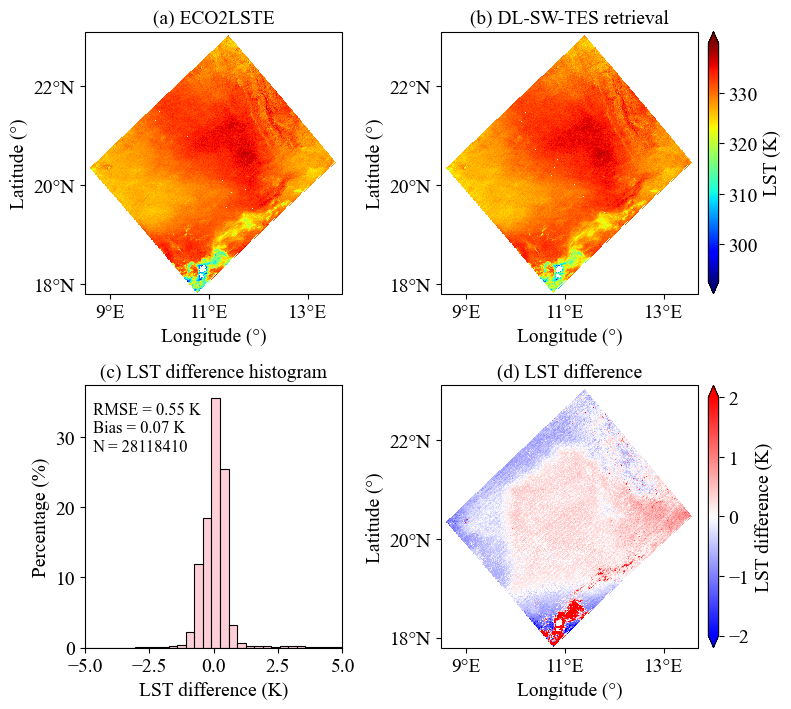

In [36]:
fig = plt.figure(figsize=(12, 8))
proj = ccrs.PlateCarree()
extent = [lon_min, lon_max, lat_min, lat_max]
extent_plot = [extent[0] // 0.1 * 0.1,
               extent[1] // 0.1 * 0.1 + 0.1,
               extent[2] // 0.1 * 0.1,
               extent[3] // 0.1 * 0.1 + 0.1]
xmin, xmax = np.ceil(extent_plot[0]), np.floor(extent_plot[1])
ymin, ymax = np.ceil(extent_plot[2]), np.floor(extent_plot[3])
ratio = (extent_plot[3]-extent_plot[2]) / (extent_plot[1]-extent_plot[0])

# subplot 1: ECOSTRESS LST image
ax = fig.add_subplot(2,2,1, projection=proj)
ax.set_extent(extent_plot, crs=proj)

im = ax.pcolormesh(lon, lat, lst_eco_high_quality, transform=proj, cmap='jet', vmin=lst_min, vmax=lst_max)
ax.set_xticks(np.arange(xmin, xmax+0.1, 2), crs=proj)
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.set_yticks(np.arange(ymin, ymax+0.1, 2), crs=proj)
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')
ax.set_title('(a) ECO2LSTE', fontsize=font_size)
'''
# add colorbar
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="4%", pad=0.1, axes_class=plt.Axes)
fig.add_axes(ax_cb)
cbar = fig.colorbar(im, cax=ax_cb, extend='both', label='LST (K)')
cbar.ax.set_title('LST (K)')
'''

# subplot 2: DL-SW-TES LST image
ax = fig.add_subplot(2,2,2, projection=proj)
ax.set_extent(extent_plot, crs=proj)
im = ax.pcolormesh(lon, lat, lst_dl_high_quality, transform=proj, cmap='jet', vmin=lst_min, vmax=lst_max)
ax.set_xticks(np.arange(xmin, xmax+0.1, 2), crs=proj)
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.set_yticks(np.arange(ymin, ymax+0.1, 2), crs=proj)
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')
# add colorbar
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="4%", pad=0.1, axes_class=plt.Axes)
fig.add_axes(ax_cb)
cbar = fig.colorbar(im, cax=ax_cb, extend='both', label='LST (K)')
ax.set_title('(b) DL-SW-TES retrieval', fontsize=font_size)


# subplot 3: LST difference histogram
ax = fig.add_subplot(2,2,3)
sns.histplot(d_lst, stat='percent', bins=bins[region], ax=ax, color='pink', edgecolor='black')
ax.text(0.03, 0.75, f'RMSE = {rmse:.2f} K\nBias = {bias:.2f} K\nN = {np.sum(qa_dl==1)}', transform=ax.transAxes, fontsize=12)
ax.set_xlim(-5, 5)
ax.set_xlabel('LST difference (K)')
ax.set_ylabel('Percentage (%)')
ax.set_box_aspect(ratio)
ax.set_title('(c) LST difference histogram', fontsize=font_size)


# subplot 4: LST spatial difference
ax = fig.add_subplot(2,2,4, projection=proj)
ax.set_extent(extent_plot, crs=proj)
im = ax.pcolormesh(lon, lat, lst_diff, transform=proj, cmap='bwr', vmin=-2, vmax=2)
ax.set_xticks(np.arange(xmin, xmax+0.1, 2), crs=proj)
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.set_yticks(np.arange(ymin, ymax+0.1, 2), crs=proj)
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')
# add colorbar
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="4%", pad=0.1, axes_class=plt.Axes)
fig.add_axes(ax_cb)
cbar = fig.colorbar(im, cax=ax_cb, extend='both', label='LST difference (K)')
ax.set_title('(d) LST difference', fontsize=font_size)


plt.subplots_adjust(hspace=hspaces, wspace=vspaces[region])

In [37]:
fig.savefig(f'figs/crossvalidation_{region}.tif', dpi=300, bbox_inches='tight')

# compare SW-TES

In [ ]:
sub_folders = glob.glob(root_folder + '/*')
df = []

for sub_folder in tqdm(sub_folders):
    file_lst_dl, file_qa_dl = os.path.join(sub_folder, 'lst_dl.npy'), os.path.join(sub_folder, 'qa_dl.npy')
    file_lst_zheng, file_qa_zheng = os.path.join(sub_folder, 'lst_zheng.npy'), os.path.join(sub_folder, 'qa_zheng.npy')
    file_lst_wang, file_qa_wang = os.path.join(sub_folder, 'lst_wang.npy'), os.path.join(sub_folder, 'qa_wang.npy')

    lst_dl, qa_dl = np.load(file_lst_dl), np.load(file_qa_dl)
    lst_zheng, qa_zheng = np.load(file_lst_zheng), np.load(file_qa_zheng)
    lst_wang, qa_wang = np.load(file_lst_wang), np.load(file_qa_wang)

    # read ECOSTRESS data
    files = sorted(glob.glob(sub_folder + '/*.h5'))
    lat, lon, vza, rad2, rad4, rad5, lst_eco, pwv, qa, land_fraction = Read_ECOSTRESS(files[0], files[1], files[3])
    lat_min, lat_max, lon_min, lon_max = np.min(lat), np.max(lat), np.min(lon), np.max(lon)
    file_mandatory = os.path.join(sub_folder, 'qa_mandatory.npy')
    qa_mandatory = np.load(file_mandatory)

    # select the common valid pixels
    idx_eco_valid = (lst_eco>0) & (qa_mandatory==0) & (land_fraction>=0.5)
    idx_final = ((idx_eco_valid) & (qa_dl==1) & (qa_zheng==1) & (qa_wang==1))

    # calculate accuracy metrics
    rmse_dl, bias_dl = root_mean_squared_error(lst_eco[idx_final], lst_dl[idx_final]), np.mean(lst_dl[idx_final]-lst_eco[idx_final])
    rmse_zheng, bias_zheng = root_mean_squared_error(lst_eco[idx_final], lst_zheng[idx_final]), np.mean(lst_zheng[idx_final]-lst_eco[idx_final])
    rmse_wang, bias_wang = root_mean_squared_error(lst_eco[idx_final], lst_wang[idx_final]), np.mean(lst_wang[idx_final]-lst_eco[idx_final])
    ratio_dl = np.sum(qa_dl==1)/np.sum(idx_eco_valid)
    ratio_zheng = np.sum(qa_zheng==1)/np.sum(idx_eco_valid)
    ratio_wang = np.sum(qa_wang==1)/np.sum(idx_eco_valid)

    region = os.path.basename(sub_folder)
    df.append({'region':region, 'rmse_dl':rmse_dl, 'rmse_zheng':rmse_zheng, 'rmse_wang':rmse_wang, 
               'bias_dl':bias_dl, 'bias_zheng':bias_zheng, 'bias_wang':bias_wang,
               'ratio_dl':ratio_dl*100, 'ratio_zheng':ratio_zheng*100, 'ratio_wang':ratio_wang*100})

df = pd.DataFrame(df)
# df.to_csv('result/accuracy_metric/crossvalidation.csv', index=False)

100%|██████████| 9/9 [01:02<00:00,  6.95s/it]


In [40]:
folder = rf'{root_folder}\ethiopia'
file_lst_dl, file_qa_dl = glob.glob(folder + '\lst_dl.npy')[0], glob.glob(folder + '\qa_dl.npy')[0]
lst_dl, qa_dl = np.load(file_lst_dl), np.load(file_qa_dl)
file_lst_zheng, file_qa_zheng = glob.glob(folder + '\lst_zheng.npy')[0], glob.glob(folder + '\qa_zheng.npy')[0]
lst_zheng, qa_zheng = np.load(file_lst_zheng), np.load(file_qa_zheng)

files = sorted(glob.glob(folder + '/*.h5'))
lat, lon, vza, rad2, rad4, rad5, lst_eco, pwv, qa, land_fraction = Read_ECOSTRESS(files[0], files[1], files[3])
lat_min, lat_max, lon_min, lon_max = np.min(lat), np.max(lat), np.min(lon), np.max(lon)
# qa_mandatory = extract_bit_vec(qa, 16, 1, 0)
# np.save(folder + '\qa_mandatory.npy', qa_mandatory.astype(np.int16))
qa_mandatory = np.load(folder + '\qa_mandatory.npy')
idx_eco_valid = (lst_eco>0) & (qa_mandatory==0) & (land_fraction>=0.5)
idx_final = ((idx_eco_valid) & (qa_dl==1) & (qa_zheng==1))

lst_eco_high_quality = np.where(idx_eco_valid, lst_eco, np.nan)
lst_dl_high_quality = np.where(qa_dl==1, lst_dl, np.nan)
lst_zheng_high_quality = np.where(qa_zheng==1, lst_zheng, np.nan)
lst_max = np.nanmax((np.nanmax(lst_eco_high_quality), np.nanmax(lst_dl_high_quality), np.nanmax(lst_zheng_high_quality)))
lst_min = np.nanmin((np.nanmin(lst_eco_high_quality), np.nanmin(lst_dl_high_quality), np.nanmin(lst_zheng_high_quality)))

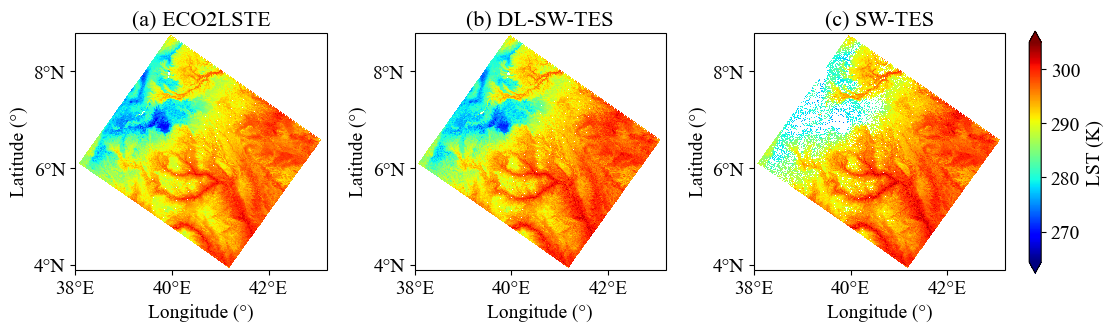

In [48]:
plt.rcParams['font.size'] = 14

proj = ccrs.PlateCarree()
extent = [lon_min, lon_max, lat_min, lat_max]
extent_plot = [extent[0] // 0.1 * 0.1,
               extent[1] // 0.1 * 0.1 + 0.1,
               extent[2] // 0.1 * 0.1,
               extent[3] // 0.1 * 0.1 + 0.1]
xmin, xmax = np.ceil(extent_plot[0]), np.floor(extent_plot[1])
ymin, ymax = np.ceil(extent_plot[2]), np.floor(extent_plot[3])
ratio = (extent_plot[3]-extent_plot[2]) / (extent_plot[1]-extent_plot[0])

fig = plt.figure(figsize=(12, 4))
# subplot 1: ECOSTRESS LST image
ax = fig.add_subplot(1,3,1, projection=proj)
ax.set_extent(extent_plot, crs=proj)
im = ax.pcolormesh(lon, lat, lst_eco_high_quality, transform=proj, cmap='jet', vmin=lst_min, vmax=lst_max)
ax.set_xticks(np.arange(xmin, xmax+0.1, 2), crs=proj)
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.set_yticks(np.arange(ymin, ymax+0.1, 2), crs=proj)
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')
ax.set_title('(a) ECO2LSTE', fontsize=16)

# subplot 2: DL-SW-TES LST image
ax = fig.add_subplot(1,3,2, projection=proj)
ax.set_extent(extent_plot, crs=proj)
im = ax.pcolormesh(lon, lat, lst_dl_high_quality, transform=proj, cmap='jet', vmin=lst_min, vmax=lst_max)
ax.set_xticks(np.arange(xmin, xmax+0.1, 2), crs=proj)
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.set_yticks(np.arange(ymin, ymax+0.1, 2), crs=proj)
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')
ax.set_title('(b) DL-SW-TES', fontsize=16)

# subplot 3: SW-TES LST image
ax = fig.add_subplot(1,3,3, projection=proj)
ax.set_extent(extent_plot, crs=proj)
im = ax.pcolormesh(lon, lat, lst_zheng_high_quality, transform=proj, cmap='jet', vmin=lst_min, vmax=lst_max)
ax.set_xticks(np.arange(xmin, xmax+0.1, 2), crs=proj)
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.set_yticks(np.arange(ymin, ymax+0.1, 2), crs=proj)
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')
ax.set_title('(c) SW-TES', fontsize=16)

plt.subplots_adjust(wspace=0.35)

# add colorbar
ax_cb = fig.add_axes([.92, 0.19, 0.01, 0.605]) # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=ax_cb, extend='both', label='LST (K)')

# fig.tight_layout()

In [49]:
fig.savefig('figs/crossvalidation_ethiopia.tif', dpi=300, bbox_inches='tight')

# LCC map

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import h5py
import glob
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from lib.utils import read_geo, Download_imgs, encode_igbp
import frykit.plot as fplt
plt.rcParams['font.family'] = 'Times New Roman'

'''
import ee
ee.Authenticate()
ee.Initialize(project='ee-zhanghuanyu21')
IGBP_img = ee.Image('MODIS/061/MCD12Q1/2022_01_01').select('LC_Type1')
# download images
region = [21, 4.5, 27, 10.5]# [lon_min, lat_min, lon_max, lat_max]
Download_imgs((IGBP_img, region, r'data/draw', 'LCC_forest', 500, None))
'''

# all files
file_lcc_germany = 'data/lcc_draw/LCC_germany.tif'
file_lcc_spain = 'data/lcc_draw/LCC_spain.tif'
file_lcc_desert = 'data/lcc_draw/LCC_desert.tif'
file_lcc_forest = 'data/lcc_draw/LCC_forest.tif'
file_lcc_all = [file_lcc_germany, file_lcc_spain, file_lcc_desert, file_lcc_forest]

file_geo_germany = glob.glob(r'H:\data\ecostress\germany\*.h5')[0]
file_geo_spain = glob.glob(r'H:\data\ecostress\spain\*.h5')[0]
file_geo_desert = glob.glob(r'H:\data\ecostress\desert\*.h5')[0]
file_geo_forest = glob.glob(r'H:\data\ecostress\forest\*.h5')[0]
file_geo_all = [file_geo_germany, file_geo_spain, file_geo_desert, file_geo_forest]

In [2]:
lon_lcc_all, lat_lcc_all, lcc_all = [], [], []
lon_geo_all, lat_geo_all = [], []

for file_lcc, file_geo in zip(file_lcc_all, file_geo_all):
    data, lon_lcc, lat_lcc = read_geo(file_lcc)
    lon_lcc_all.append(lon_lcc)
    lat_lcc_all.append(lat_lcc)
    lcc_all.append(encode_igbp(data.astype(np.float32)))

    f_geo = h5py.File(file_geo, 'r')
    lat_geo, lon_geo = f_geo['Geolocation']['latitude'][:], f_geo['Geolocation']['longitude'][:]
    f_geo.close()
    lon_geo_all.append(lon_geo)
    lat_geo_all.append(lat_geo)

In [3]:
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.cm as cm

# colors = np.array(['#05450a', '#086a10', '#54a708', '#78d203', '#009900', '#c6b044', '#dcd159','#dade48', '#fbff13', 
#           '#b6ff05', '#27ff87', '#c24f44', '#a5a5a5', '#ff6d4c', '#69fff8', '#f9ffa4', '#86A8E7'])
colors = np.array(['#05450a', '#54a708', '#fbff13', '#b6ff05', '#27ff87', '#ff6d4c', '#a5a5a5', '#69fff8', '#f9ffa4', '#86A8E7'])
value_all = np.arange(100, 1001, 100)

labels = ['Forest', 'Shrubland', 'Savanna', 'Grassland', 'Wetland', 'Cropland', 'Urban', 'Snow/Ice', 'Barren', 'Water']

bounds = np.append(value_all, 1100)
cmap = ListedColormap(colors)
norm = BoundaryNorm(bounds, cmap.N)

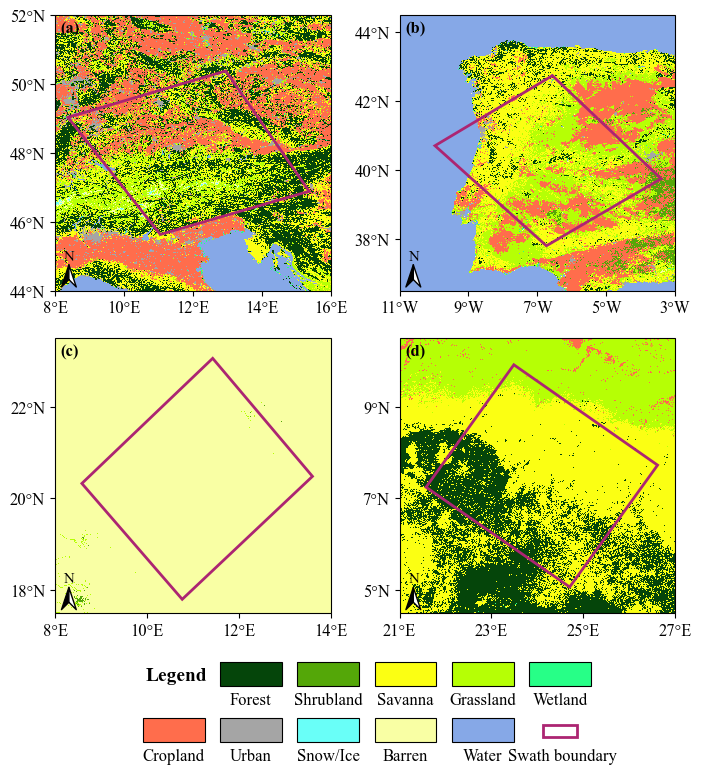

In [ ]:
plt.rcParams['font.size'] = 12
proj = ccrs.PlateCarree()
fig, axs = plt.subplots(2, 2, figsize=(8, 8), subplot_kw={'projection': proj})

# lon_min, lon_max, lat_min, lat_max
extents = [[8, 16, 44, 52],
           [-11, -3, 36.5, 44.5],
           [8, 14, 17.5, 23.5],
           [21, 27, 4.5, 10.5]]

for i in range(4):
    ax = axs[i//2,i%2]
    ax.set_extent(extents[i], crs=proj)
    xmin, xmax = np.ceil(extents[i][0]), np.floor(extents[i][1])
    ymin, ymax = np.ceil(extents[i][2]), np.floor(extents[i][3])
    if i==1:
        ymin, ymax = ymin+1, ymax+1
    # plot LCC map
    ax.pcolormesh(lon_lcc_all[i], lat_lcc_all[i], lcc_all[i], transform=proj, cmap=cmap, norm=norm)
    # add swath boundary
    lat_i, lon_i = lat_geo_all[i], lon_geo_all[i]
    corners = np.array([[lon_i[0,0], lat_i[0,0]], [lon_i[0,-1], lat_i[0,-1]], [lon_i[-1,-1], lat_i[-1,-1]], [lon_i[-1,0], lat_i[-1,0]]])
    polygon1 = patches.Polygon(corners, closed=True, edgecolor='#AC2572', linewidth=2, fill=False)
    ax.add_patch(polygon1)
    
    fplt.add_compass(ax, 0.05, 0.04, size=16, style='arrow')
    ax.text(0.02, 0.94, f'({chr(97+i)})', weight='bold', transform=ax.transAxes)
    ax.set_xticks(np.arange(xmin,xmax+0.1,2), crs=proj)
    ax.set_yticks(np.arange(ymin,ymax+0.1,2), crs=proj)
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())

# add colorbar
single_width = axs[0,0].get_position().width
total_width = single_width+axs[0,1].get_position().x0-axs[0,0].get_position().x0
x0 = axs[1,0].get_position().x0
y0 = axs[1,0].get_position().y0
for i in range(10):
    if i<5:
        cax_i = fig.add_axes([x0+total_width/8*i+0.205, y0-0.08, total_width/10, 0.03])
    else:
        cax_i = fig.add_axes([x0+total_width/8*(i-6)+0.205, y0-0.15, total_width/10, 0.03])

    cmap_i = ListedColormap(colors[i])
    im_i = cm.ScalarMappable(cmap=cmap_i)
    cb_i = fig.colorbar(im_i, cax=cax_i, orientation='horizontal')
    cb_i.set_label(labels[i])
    cb_i.set_ticks([])

axs[1,0].text(0.44, -0.225, 'Legend', transform=axs[1,0].transAxes, ha='center', va='center', fontsize=14, weight='bold')
axs[1,1].legend([' '], loc='upper center', frameon=False, bbox_to_anchor=(0.59, -0.35), handletextpad=0.0)
axs[1,1].text(0.59, -0.518, 'Swath boundary', transform=axs[1,1].transAxes, ha='center', va='center')

plt.subplots_adjust(hspace=0.1, wspace=0.25)

In [16]:
fig.savefig('figs/crossvalidation_regions.tif', dpi=300, bbox_inches='tight')